## Importing Libraries

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import train_test_split, cross_val_score , GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler , OneHotEncoder , MinMaxScaler ,OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report , roc_auc_score, RocCurveDisplay, precision_score, recall_score, f1_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('rheumatoid_arthritis_dataset.csv')

## Data Understanding

In [3]:
df.head()

,SEQN,RheumatoidArthritis,BRI,Gender,Age,Race,EducationLevel,MaritalStatus,FamilyIncome,PhysicalActivity,...,ProteinConsumption,CarbohydrateConsumption,FatConsumption,CaffeineConsumption,FiberConsumption,PSU,STRATA,BRI_Grp,BRI_Trend,Weight
0,62161,0,2.815371,Male,22,Non-Hispanic White,High school graduate,Living Alone,"(1.3,3.5]",Other,...,104.68,359.59,123.81,0,18.6,1,91,"[1.049, 3.666]",0,22313.349230
1,62169,0,2.017701,Male,21,Other,High school graduate,Living Alone,PIR <= 1.3,Other,...,77.46,297.51,34.61,40,4.3,1,92,"[1.049, 3.666]",0,3128.647493
2,62172,0,7.888557,Female,43,Non-Hispanic Black,High school graduate,Living Alone,"(1.3,3.5]",Sedentary,...,57.43,192.82,42.02,54,2.8,2,96,"(6.477, 20.970]",3,5861.037901
3,62176,0,3.760754,Female,34,Non-Hispanic White,Above high school,Living With A Partner,PIR > 3.5,Vigorous activity,...,144.81,281.44,112.90,197,41.9,1,99,"(3.666, 4.924]",1,11702.304220
4,62178,1,6.569817,Male,80,Non-Hispanic White,High school graduate,Living Alone,PIR <= 1.3,Other,...,48.71,302.33,79.97,17,14.0,1,95,"(6.477, 20.970]",3,2671.990112


In [4]:
df.shape

(13273, 27)

In [5]:
df.dtypes.value_counts()

object     12
int64       8
float64     7
Name: count, dtype: int64

In [6]:
df.isnull().sum()

SEQN                       0
RheumatoidArthritis        0
BRI                        0
Gender                     0
Age                        0
Race                       0
EducationLevel             0
MaritalStatus              0
FamilyIncome               0
PhysicalActivity           0
SmokingStatus              0
BMI                        0
DrinkingStatus             0
Hypertension               0
Diabetes                   0
Hyperlipidemia             0
CalorieConsumption         0
ProteinConsumption         0
CarbohydrateConsumption    0
FatConsumption             0
CaffeineConsumption        0
FiberConsumption           0
PSU                        0
STRATA                     0
BRI_Grp                    0
BRI_Trend                  0
Weight                     0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13273 entries, 0 to 13272
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SEQN                     13273 non-null  int64  
 1   RheumatoidArthritis      13273 non-null  int64  
 2   BRI                      13273 non-null  float64
 3   Gender                   13273 non-null  object 
 4   Age                      13273 non-null  int64  
 5   Race                     13273 non-null  object 
 6   EducationLevel           13273 non-null  object 
 7   MaritalStatus            13273 non-null  object 
 8   FamilyIncome             13273 non-null  object 
 9   PhysicalActivity         13273 non-null  object 
 10  SmokingStatus            13273 non-null  object 
 11  BMI                      13273 non-null  float64
 12  DrinkingStatus           13273 non-null  object 
 13  Hypertension             13273 non-null  object 
 14  Diabetes              

In [8]:
df.duplicated().sum()

0

In [9]:
df.drop(columns = ['SEQN', 'PSU', 'STRATA', 'BRI_Grp', 'BRI_Trend', 'Weight'], inplace = True)

In [10]:
df.columns

Index(['RheumatoidArthritis', 'BRI', 'Gender', 'Age', 'Race', 'EducationLevel',
       'MaritalStatus', 'FamilyIncome', 'PhysicalActivity', 'SmokingStatus',
       'BMI', 'DrinkingStatus', 'Hypertension', 'Diabetes', 'Hyperlipidemia',
       'CalorieConsumption', 'ProteinConsumption', 'CarbohydrateConsumption',
       'FatConsumption', 'CaffeineConsumption', 'FiberConsumption'],
      dtype='object')

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RheumatoidArthritis,13273.0,0.062533,0.242130,0.000000,0.000000,0.000000,0.000000,1.000000
BRI,13273.0,5.317289,2.328315,1.048869,3.665968,4.924353,6.476923,20.970057
Age,13273.0,45.123032,16.696345,20.000000,31.000000,43.000000,58.000000,80.000000
BMI,13273.0,28.887750,6.869709,14.100000,24.000000,27.800000,32.400000,82.000000
CalorieConsumption,13273.0,2178.910872,1020.844450,0.000000,1489.000000,2006.000000,2668.000000,13687.000000
ProteinConsumption,13273.0,83.273651,44.208148,0.000000,53.630000,75.330000,103.170000,557.870000
CarbohydrateConsumption,13273.0,256.412823,127.097817,0.000000,169.470000,235.830000,317.330000,1815.020000
FatConsumption,13273.0,84.772704,48.666870,0.000000,51.420000,75.970000,108.000000,553.790000
CaffeineConsumption,13273.0,136.733218,182.296488,0.000000,9.000000,90.000000,194.000000,4320.000000
FiberConsumption,13273.0,17.074934,10.998244,0.000000,9.500000,14.700000,22.000000,136.300000


In [12]:
cols = df.columns
cols

Index(['RheumatoidArthritis', 'BRI', 'Gender', 'Age', 'Race', 'EducationLevel',
       'MaritalStatus', 'FamilyIncome', 'PhysicalActivity', 'SmokingStatus',
       'BMI', 'DrinkingStatus', 'Hypertension', 'Diabetes', 'Hyperlipidemia',
       'CalorieConsumption', 'ProteinConsumption', 'CarbohydrateConsumption',
       'FatConsumption', 'CaffeineConsumption', 'FiberConsumption'],
      dtype='object')

In [13]:
cat_cols = df.select_dtypes('object').columns
for col in cat_cols:
    print("----------------------------")
    print(col, " → ", df[col].unique())
    print(df[col].value_counts())
    print()

----------------------------
Gender  →  ['Male' 'Female']
Gender
Male      6847
Female    6426
Name: count, dtype: int64

----------------------------
Race  →  ['Non-Hispanic White' 'Other' 'Non-Hispanic Black' 'Mexican American']
Race
Non-Hispanic White    4778
Other                 3574
Non-Hispanic Black    3117
Mexican American      1804
Name: count, dtype: int64

----------------------------
EducationLevel  →  ['High school graduate' 'Above high school' 'Below high school']
EducationLevel
Above high school       7962
High school graduate    2940
Below high school       2371
Name: count, dtype: int64

----------------------------
MaritalStatus  →  ['Living Alone' 'Living With A Partner']
MaritalStatus
Living With A Partner    7845
Living Alone             5428
Name: count, dtype: int64

----------------------------
FamilyIncome  →  ['(1.3,3.5]' 'PIR <= 1.3' 'PIR > 3.5']
FamilyIncome
(1.3,3.5]     4908
PIR > 3.5     4316
PIR <= 1.3    4049
Name: count, dtype: int64

----------------

In [14]:
df['RheumatoidArthritis'].value_counts()

RheumatoidArthritis
0    12443
1      830
Name: count, dtype: int64

In [15]:
df['RheumatoidArthritis'].value_counts(normalize=True) * 100

RheumatoidArthritis
0    93.746704
1     6.253296
Name: proportion, dtype: float64

In [16]:
df[['BRI','Age','CalorieConsumption' ,'CaffeineConsumption']].skew()

BRI                    1.218270
Age                    0.347654
CalorieConsumption     1.622224
CaffeineConsumption    5.042350
dtype: float64

# Data Analysis

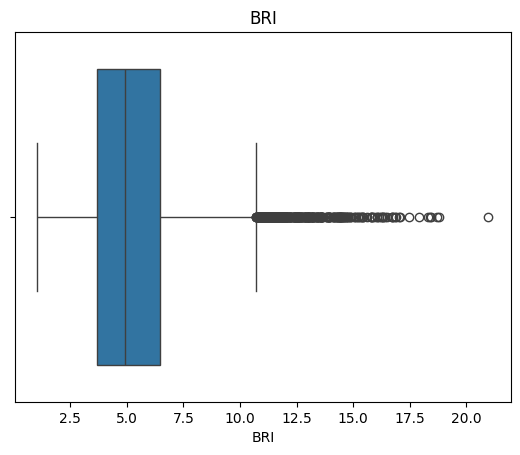

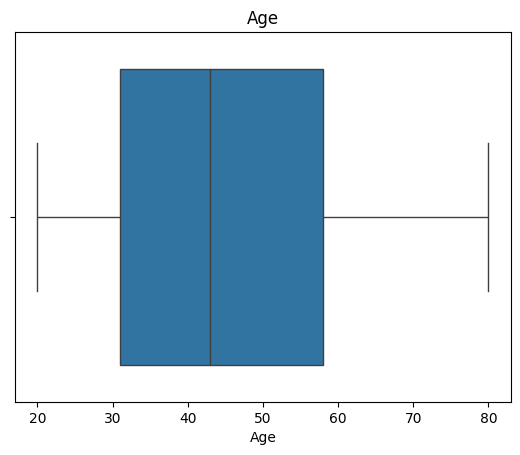

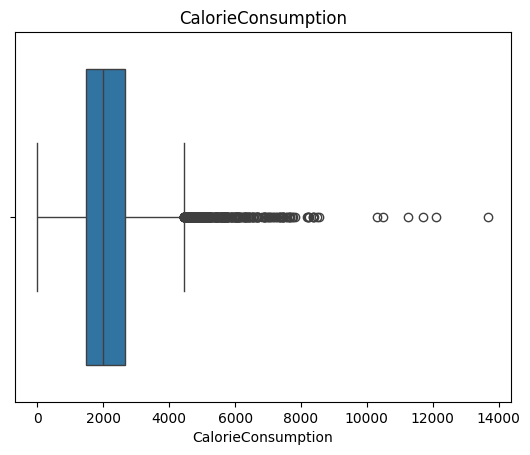

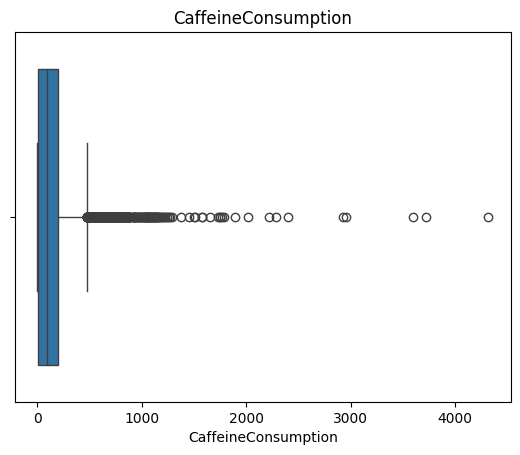

In [17]:
for col in ['BRI','Age','CalorieConsumption','CaffeineConsumption']:
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()

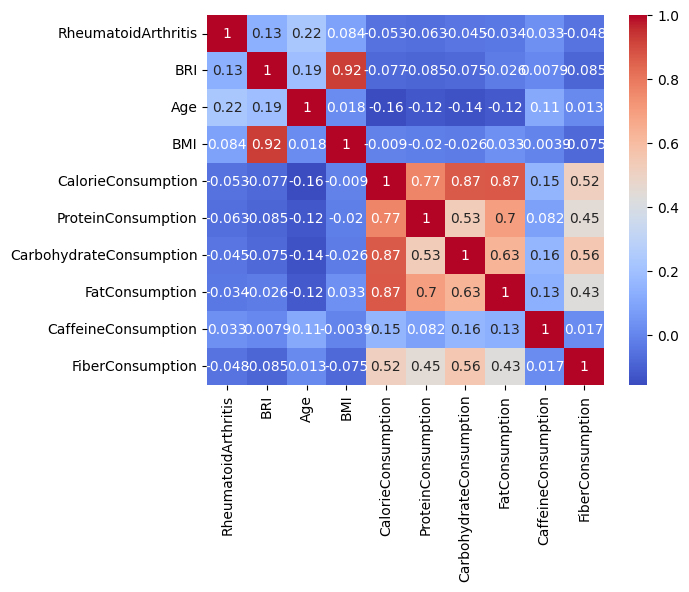

In [18]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

In [19]:
df.drop(columns = ['ProteinConsumption', 'CarbohydrateConsumption','FatConsumption', 'FiberConsumption', 'BMI'], inplace = True)

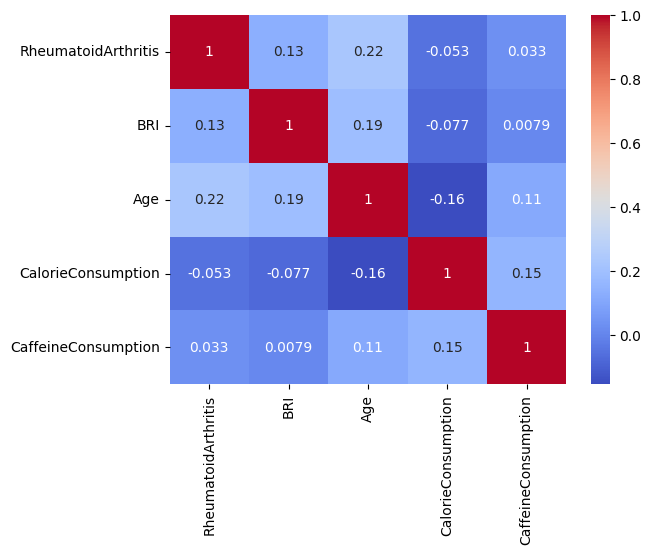

In [20]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

To improve model efficiency and reduce unnecessary noise, we removed a few features—ProteinConsumption, CarbohydrateConsumption, FatConsumption, FiberConsumption, and BMI. These variables showed very weak or redundant correlations with the target (Rheumatoid Arthritis) in the heatmap, meaning they were not contributing meaningful predictive information. Some of them were also highly correlated with other nutritional features, which can introduce multicollinearity. By dropping these columns, the model becomes simpler, faster, and less prone to overfitting, while keeping only the features that add real value.

In [21]:
num_cols = df.select_dtypes(exclude='object').columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

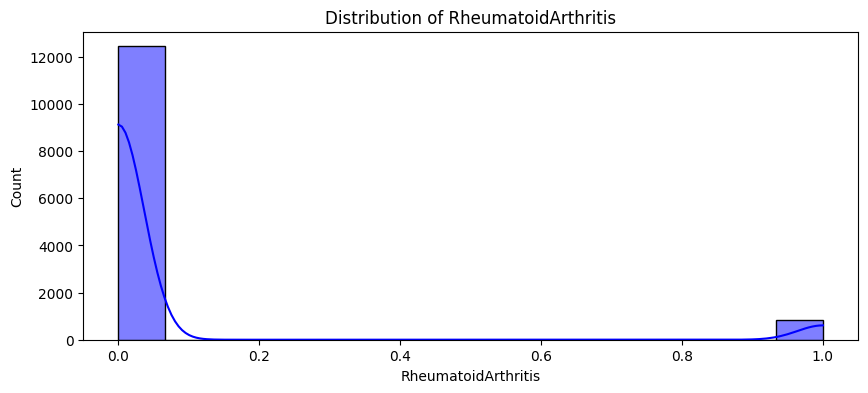

RheumatoidArthritis → Mean: 0.06
, Median: 0.00
, Skew: 3.61
, Kurtosis: 11.06


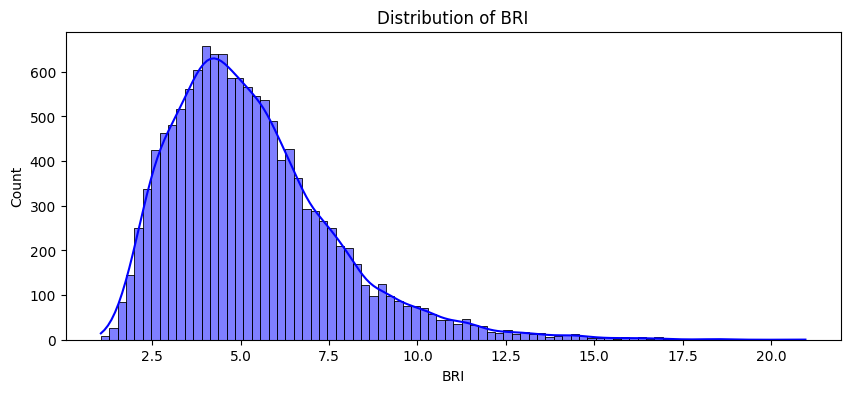

BRI → Mean: 5.32
, Median: 4.92
, Skew: 1.22
, Kurtosis: 2.41


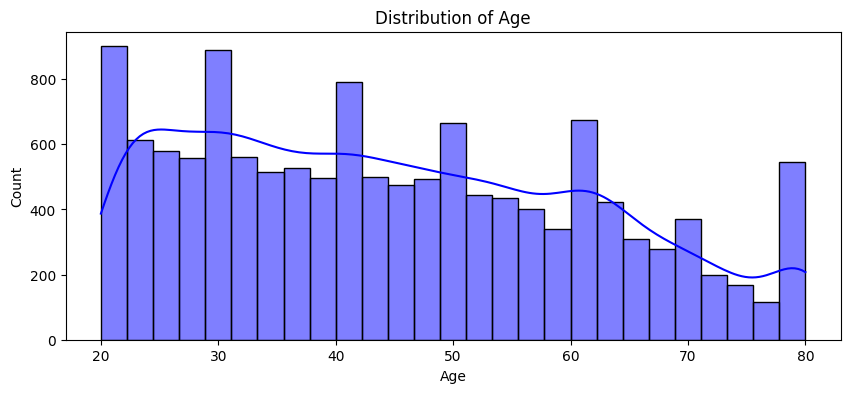

Age → Mean: 45.12
, Median: 43.00
, Skew: 0.35
, Kurtosis: -0.90


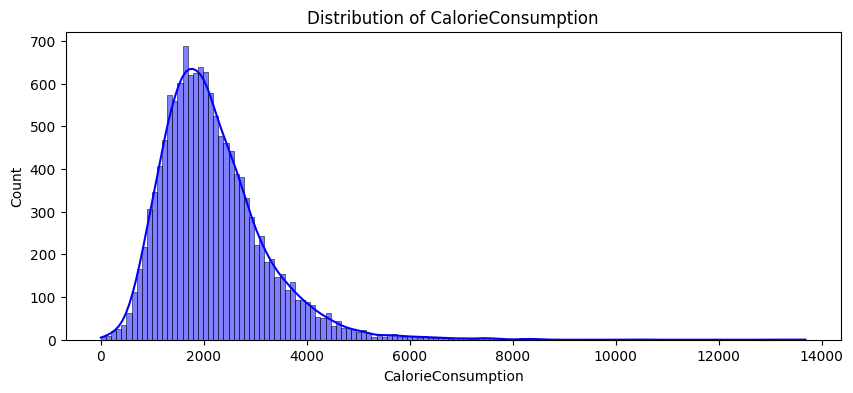

CalorieConsumption → Mean: 2178.91
, Median: 2006.00
, Skew: 1.62
, Kurtosis: 6.56


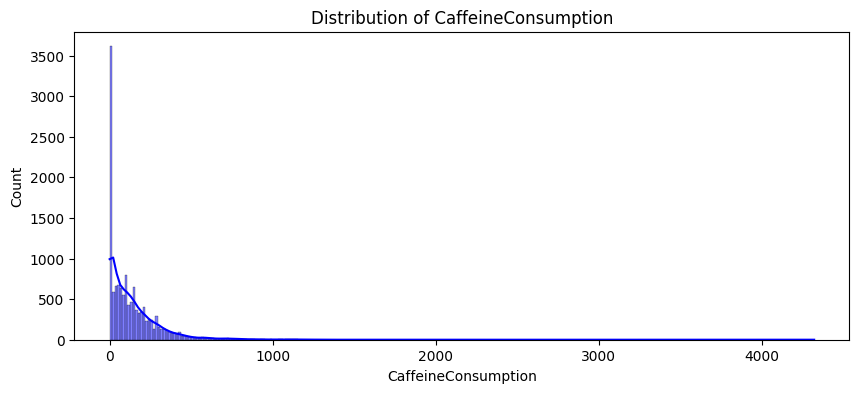

CaffeineConsumption → Mean: 136.73
, Median: 90.00
, Skew: 5.04
, Kurtosis: 63.71


In [22]:
for col in num_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f"Distribution of {col}")
    plt.show()

    mean = df[col].mean()
    median = df[col].median()
    skewness = df[col].skew()
    kurtosis = df[col].kurt()
    print(f"{col} → Mean: {mean:.2f}\n, Median: {median:.2f}\n, Skew: {skewness:.2f}\n, Kurtosis: {kurtosis:.2f}")

In [23]:
def outlier_summary(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = ((series < lower) | (series > upper)).sum()
    return outliers

print("\n--> Outlier counts per feature:")
for col in num_cols:
    print(f"{col}: {outlier_summary(df[col])}")


--> Outlier counts per feature:
RheumatoidArthritis: 830
BRI: 404
Age: 0
CalorieConsumption: 387
CaffeineConsumption: 537


In [24]:
cat_cols = ['Gender','Race','EducationLevel','MaritalStatus','FamilyIncome',
            'PhysicalActivity','SmokingStatus','DrinkingStatus',
            'Hypertension','Diabetes','Hyperlipidemia']

for col in cat_cols:
    print(f"\n--- {col} vs RA ---")
    print(pd.crosstab(df[col], df['RheumatoidArthritis'], normalize='index'))


--- Gender vs RA ---
RheumatoidArthritis         0         1
Gender                                 
Female               0.926082  0.073918
Male                 0.948152  0.051848

--- Race vs RA ---
RheumatoidArthritis         0         1
Race                                   
Mexican American     0.945676  0.054324
Non-Hispanic Black   0.912095  0.087905
Non-Hispanic White   0.937212  0.062788
Other                0.955792  0.044208

--- EducationLevel vs RA ---
RheumatoidArthritis          0         1
EducationLevel                          
Above high school     0.948003  0.051997
Below high school     0.915226  0.084774
High school graduate  0.926871  0.073129

--- MaritalStatus vs RA ---
RheumatoidArthritis           0         1
MaritalStatus                            
Living Alone           0.932203  0.067797
Living With A Partner  0.941109  0.058891

--- FamilyIncome vs RA ---
RheumatoidArthritis         0         1
FamilyIncome                           
(1.3,3.5]         

In [25]:
df.columns

Index(['RheumatoidArthritis', 'BRI', 'Gender', 'Age', 'Race', 'EducationLevel',
       'MaritalStatus', 'FamilyIncome', 'PhysicalActivity', 'SmokingStatus',
       'DrinkingStatus', 'Hypertension', 'Diabetes', 'Hyperlipidemia',
       'CalorieConsumption', 'CaffeineConsumption'],
      dtype='object')

In [26]:
cat_cols.remove('Race')



===== Gender vs RheumatoidArthritis =====

Counts:
RheumatoidArthritis     0    1
Gender                        
Female               5951  475
Male                 6492  355

Percentage Row-wise:
RheumatoidArthritis          0         1
Gender                                  
Female               92.608154  7.391846
Male                 94.815248  5.184752


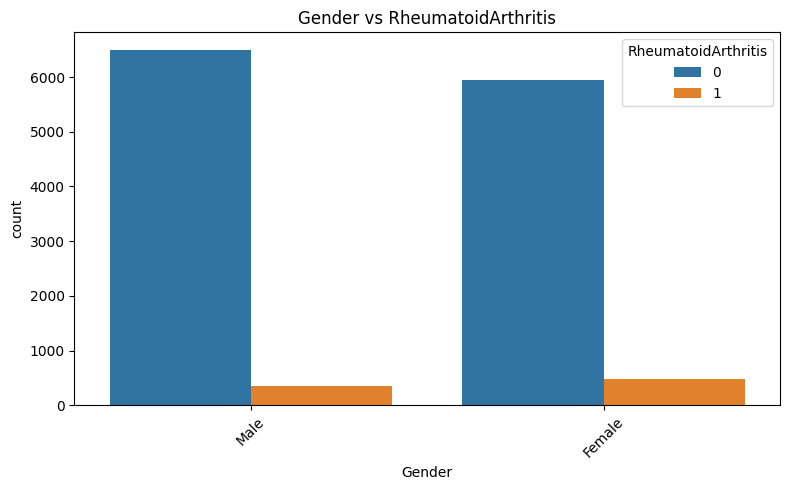



===== EducationLevel vs RheumatoidArthritis =====

Counts:
RheumatoidArthritis      0    1
EducationLevel                 
Above high school     7548  414
Below high school     2170  201
High school graduate  2725  215

Percentage Row-wise:
RheumatoidArthritis           0         1
EducationLevel                           
Above high school     94.800301  5.199699
Below high school     91.522564  8.477436
High school graduate  92.687075  7.312925


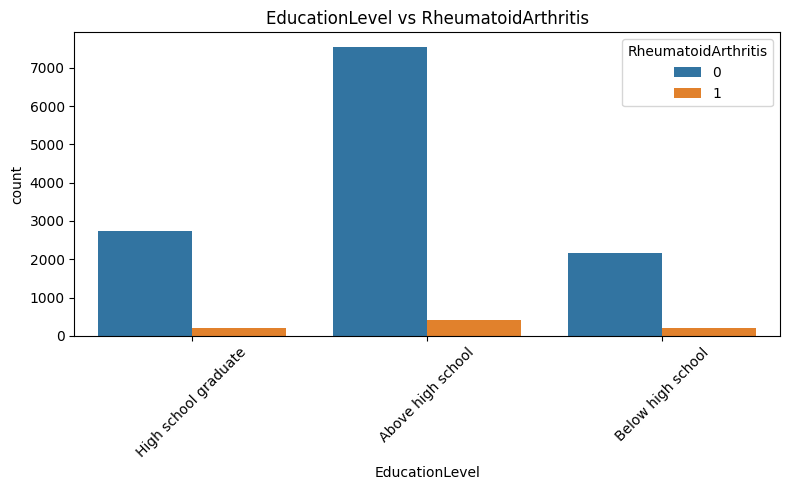



===== MaritalStatus vs RheumatoidArthritis =====

Counts:
RheumatoidArthritis       0    1
MaritalStatus                   
Living Alone           5060  368
Living With A Partner  7383  462

Percentage Row-wise:
RheumatoidArthritis            0         1
MaritalStatus                             
Living Alone           93.220339  6.779661
Living With A Partner  94.110899  5.889101


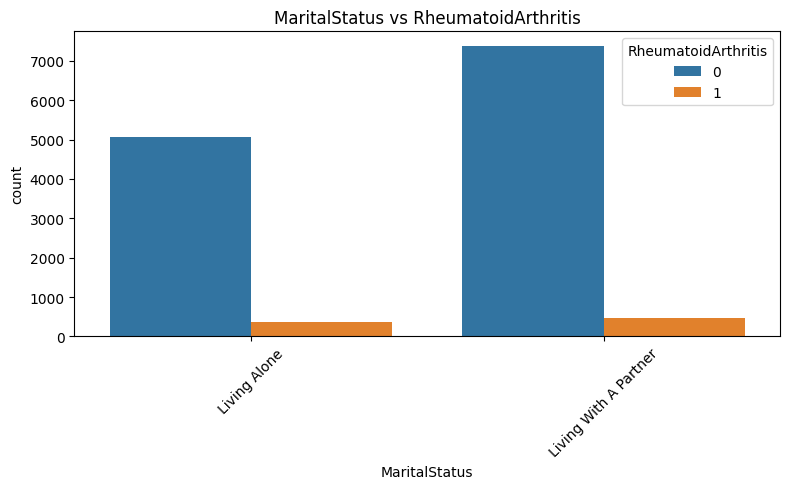



===== FamilyIncome vs RheumatoidArthritis =====

Counts:
RheumatoidArthritis     0    1
FamilyIncome                  
(1.3,3.5]            4623  285
PIR <= 1.3           3715  334
PIR > 3.5            4105  211

Percentage Row-wise:
RheumatoidArthritis          0         1
FamilyIncome                            
(1.3,3.5]            94.193154  5.806846
PIR <= 1.3           91.751050  8.248950
PIR > 3.5            95.111214  4.888786


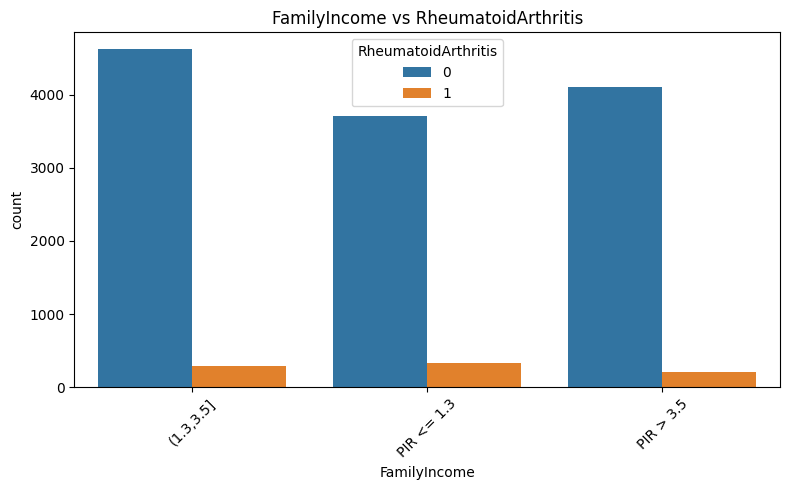



===== PhysicalActivity vs RheumatoidArthritis =====

Counts:
RheumatoidArthritis     0    1
PhysicalActivity              
Moderate activity    3156  228
Other                4599  416
Sedentary             998   90
Vigorous activity    3690   96

Percentage Row-wise:
RheumatoidArthritis          0         1
PhysicalActivity                        
Moderate activity    93.262411  6.737589
Other                91.704885  8.295115
Sedentary            91.727941  8.272059
Vigorous activity    97.464342  2.535658


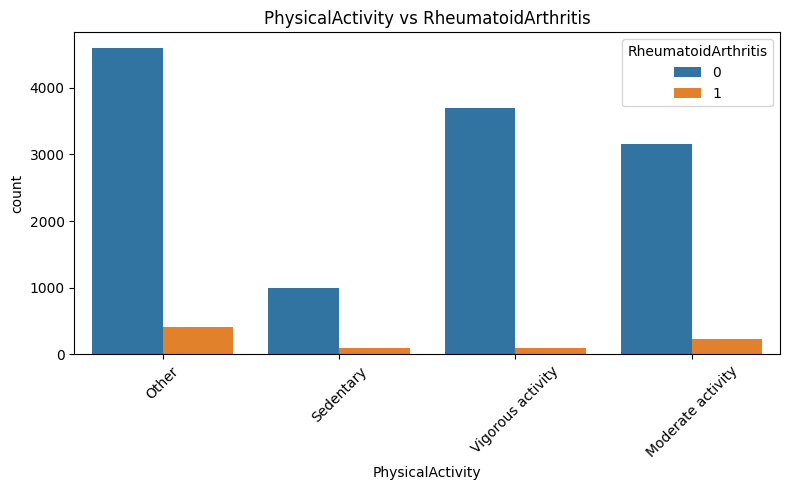



===== SmokingStatus vs RheumatoidArthritis =====

Counts:
RheumatoidArthritis     0    1
SmokingStatus                 
Current              2379  187
Former               2403  231
Never                7661  412

Percentage Row-wise:
RheumatoidArthritis          0         1
SmokingStatus                           
Current              92.712393  7.287607
Former               91.230068  8.769932
Never                94.896569  5.103431


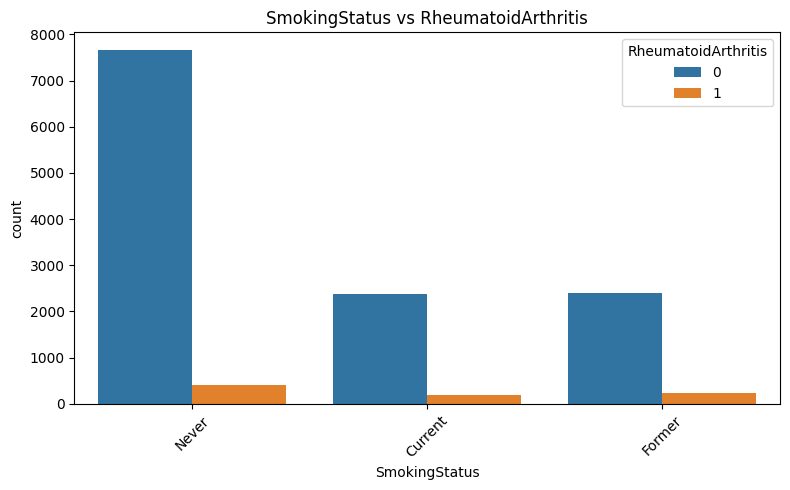



===== DrinkingStatus vs RheumatoidArthritis =====

Counts:
RheumatoidArthritis     0    1
DrinkingStatus                
Almost non-drinker   2810  278
Frequent drinker     3968  214
Occasional drinker   5665  338

Percentage Row-wise:
RheumatoidArthritis          0         1
DrinkingStatus                          
Almost non-drinker   90.997409  9.002591
Frequent drinker     94.882831  5.117169
Occasional drinker   94.369482  5.630518


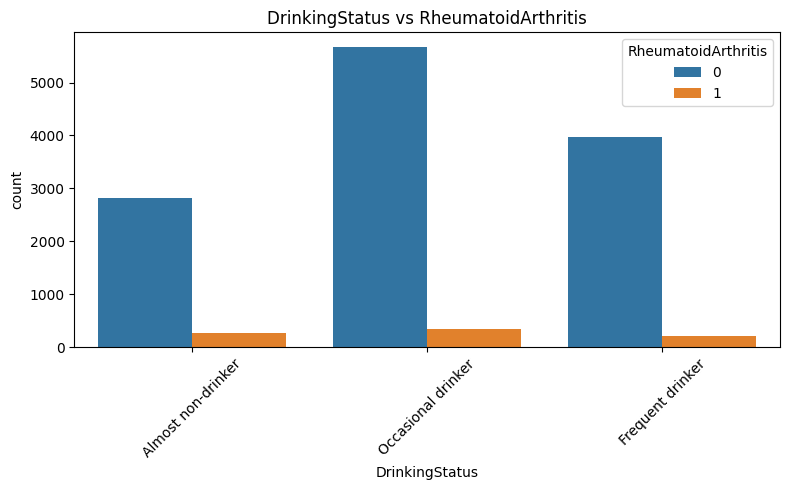



===== Hypertension vs RheumatoidArthritis =====

Counts:
RheumatoidArthritis     0    1
Hypertension                  
Hypertension         3338  494
Normal               9105  336

Percentage Row-wise:
RheumatoidArthritis          0          1
Hypertension                             
Hypertension         87.108559  12.891441
Normal               96.441055   3.558945


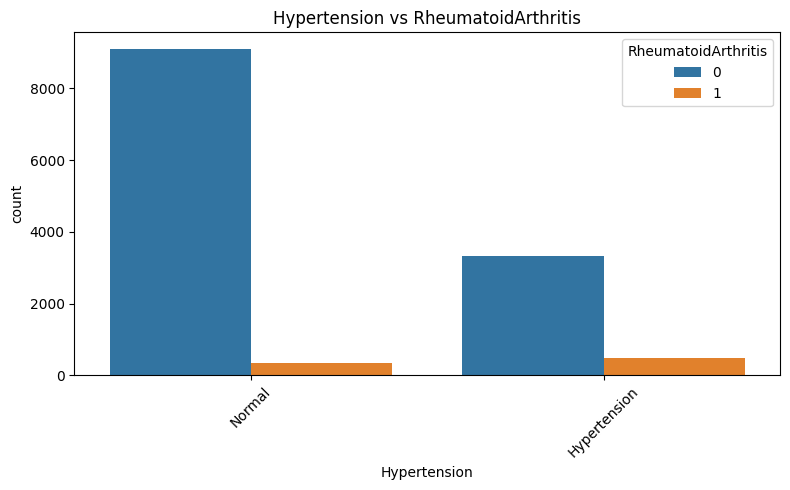



===== Diabetes vs RheumatoidArthritis =====

Counts:
RheumatoidArthritis      0    1
Diabetes                       
Diabetes              1204  227
Normal               10426  528
Prediabetes            813   75

Percentage Row-wise:
RheumatoidArthritis          0          1
Diabetes                                 
Diabetes             84.136967  15.863033
Normal               95.179843   4.820157
Prediabetes          91.554054   8.445946


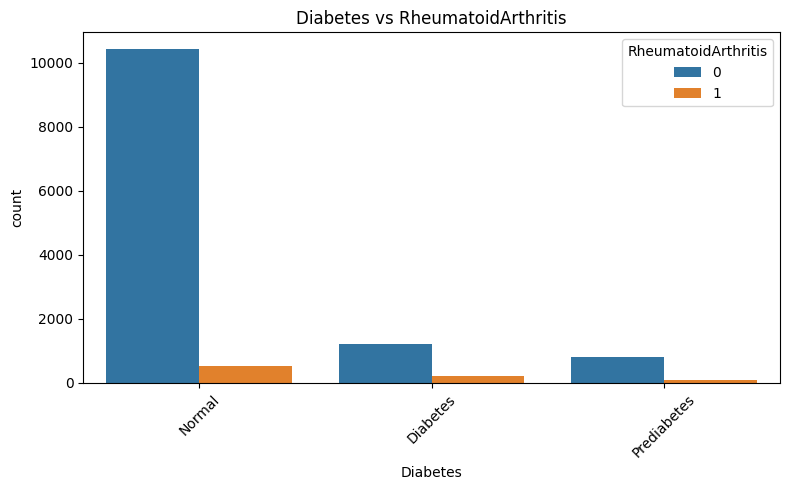



===== Hyperlipidemia vs RheumatoidArthritis =====

Counts:
RheumatoidArthritis     0    1
Hyperlipidemia                
Hyperlipidemia       7923  664
Normal               4520  166

Percentage Row-wise:
RheumatoidArthritis          0         1
Hyperlipidemia                          
Hyperlipidemia       92.267381  7.732619
Normal               96.457533  3.542467


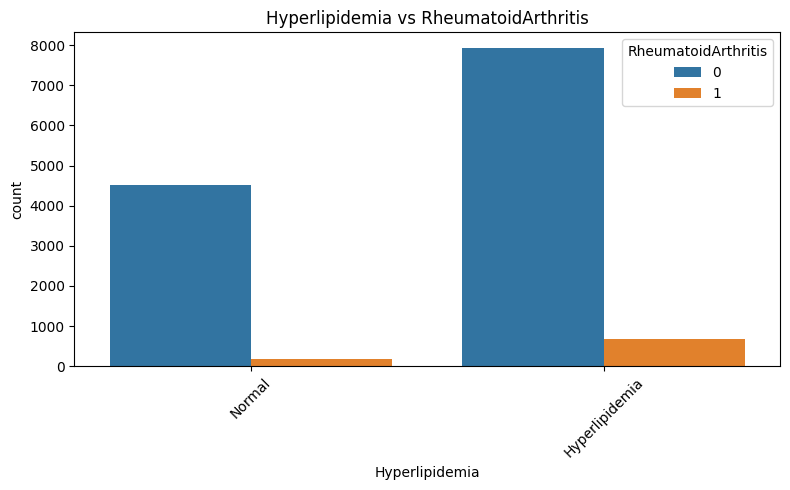

In [27]:
for col in cat_cols:
    print(f"\n\n===== {col} vs RheumatoidArthritis =====")
    
    ct = pd.crosstab(df[col], df['RheumatoidArthritis'])
    print("\nCounts:")
    print(ct)
    
    print("\nPercentage Row-wise:")
    print(ct.div(ct.sum(axis=1), axis=0) * 100)
    
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x=col, hue='RheumatoidArthritis')
    plt.xticks(rotation=45)
    plt.title(f"{col} vs RheumatoidArthritis")
    plt.tight_layout()
    plt.show()

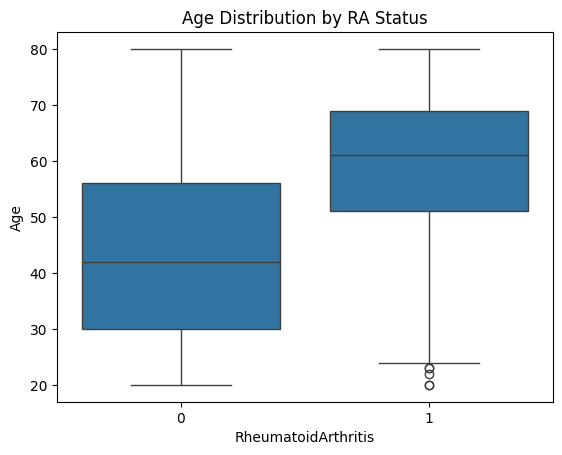

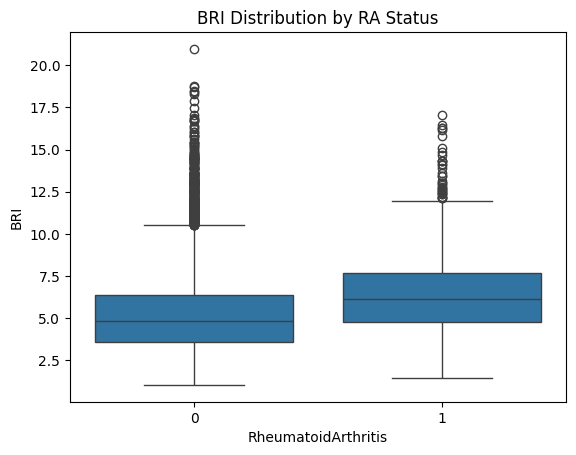

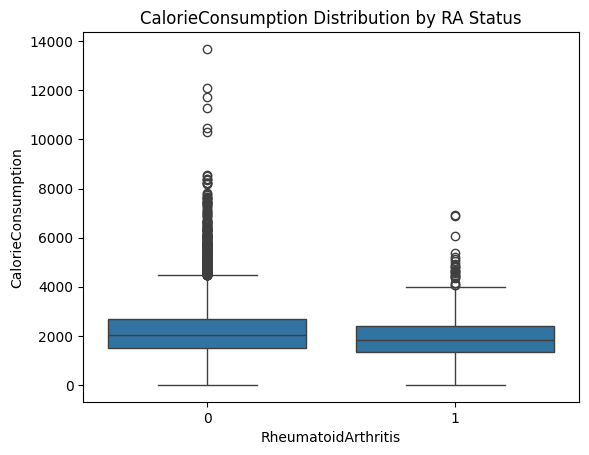

In [28]:
for col in ['Age','BRI','CalorieConsumption']:
    sns.boxplot(data=df, x='RheumatoidArthritis', y=col)
    plt.title(f"{col} Distribution by RA Status")
    plt.show()

<Axes: xlabel='RheumatoidArthritis', ylabel='count'>

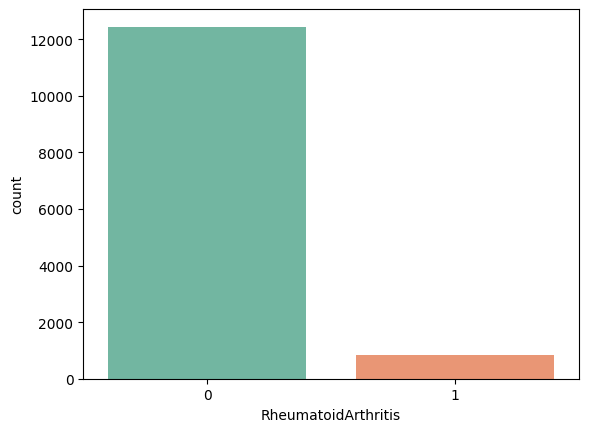

In [29]:
sns.countplot(data=df, x="RheumatoidArthritis", palette='Set2')

# Data Preprocessing & Feature Engineering

In [30]:
df['AgeGroup'] = pd.cut(df['Age'], bins=[0,30,45,60,100], labels=['Young','Adult','MidAge','Old'])

df['CalorieConsumption'] = df.apply(
    lambda row: df[
        (df['Gender'] == row['Gender']) &
        (df['AgeGroup'] == row['AgeGroup'])
    ]['CalorieConsumption'].median()
    if row['CalorieConsumption'] == 0 else row['CalorieConsumption'],
    axis=1
)

In [31]:
df.drop(columns=['AgeGroup'], inplace=True)

In [32]:
Q1 = df['CalorieConsumption'].quantile(0.25)
Q3 = df['CalorieConsumption'].quantile(0.75)
IQR = Q3 - Q1
upper = min(Q3 + 1.5*IQR, df['CalorieConsumption'].quantile(0.995))

df['CalorieConsumption'] = df['CalorieConsumption'].clip(lower=800, upper=upper)

In [33]:
Q1 = df['BRI'].quantile(0.25)
Q3 = df['BRI'].quantile(0.75)
IQR = Q3 - Q1
upper = min(Q3 + 1.5*IQR, df['BRI'].quantile(0.995))

df['BRI'] = df['BRI'].clip(lower=1.0, upper=upper)

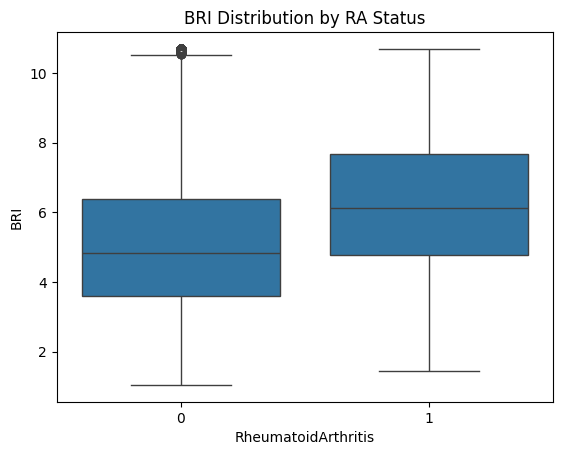

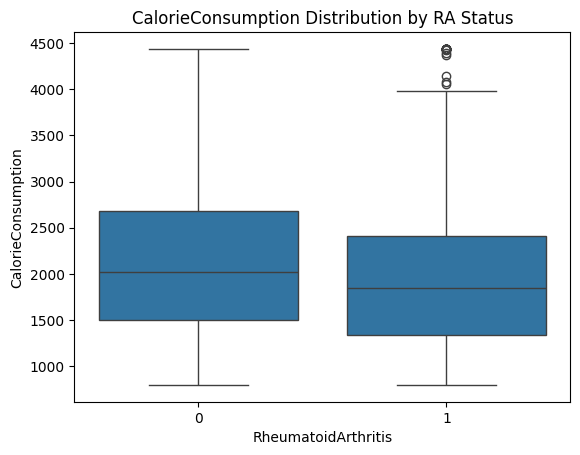

In [34]:
for col in ['BRI','CalorieConsumption']:
    sns.boxplot(data=df, x='RheumatoidArthritis', y=col)
    plt.title(f"{col} Distribution by RA Status")
    plt.show()

In [35]:
df['Gender'] = df['Gender'].map({'Male':0,'Female':1})
df['MaritalStatus'] = df['MaritalStatus'].map({'Living Alone':0,'Living With A Partner':1})
df['Hypertension'] = df['Hypertension'].map({'Normal':0,'Hypertension':1})
df['Hyperlipidemia'] = df['Hyperlipidemia'].map({'Normal':0,'Hyperlipidemia':1})

In [36]:
df['EducationLevel'] = df['EducationLevel'].map({
    'Below high school':0,
    'High school graduate':1,
    'Above high school':2
})

In [37]:
df['Diabetes'] = df['Diabetes'].map({'Normal':0,'Prediabetes':1,'Diabetes':2})

In [38]:
df['SmokingStatus'] = df['SmokingStatus'].map({'Never':0,'Former':1,'Current':2})

In [39]:
df['DrinkingStatus'] = df['DrinkingStatus'].map({
    'Almost non-drinker':2,
    'Occasional drinker':1,
    'Frequent drinker':0
})

In [40]:
df['FamilyIncome'] = df['FamilyIncome'].map({
    'PIR <= 1.3':0,
    '(1.3,3.5]':1,
    'PIR > 3.5':2
})

In [41]:
df = pd.get_dummies(df, columns=['Race','PhysicalActivity'], drop_first=True)

In [42]:
df.shape

(13273, 20)

In [43]:
X = df.drop('RheumatoidArthritis', axis=1)
y = df['RheumatoidArthritis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

In [44]:
num_cols = ['Age','BRI','CalorieConsumption','CaffeineConsumption']
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [45]:
categorical_cols = [
    col for col in X_train.columns 
    if col not in ['Age','BRI','CalorieConsumption','CaffeineConsumption']
]

categorical_indices = [X_train.columns.get_loc(c) for c in categorical_cols]

smote = SMOTENC(categorical_features=categorical_indices, random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Our dataset was highly imbalanced, with far fewer cases of Rheumatoid Arthritis compared to non-RA cases. Training a model on such uneven data can cause it to ignore the minority class completely. We used SMOTENC, a version of SMOTE designed specifically for datasets that contain both numeric and categorical features. It creates realistic synthetic samples for the minority class while respecting the structure of categorical variables. This helped us balance the dataset, improve recall for RA cases, and make the model more fair and sensitive to positive predictions.

# Data Modelling & Evaluation

## Logistic Regression

Train class distribution:
 RheumatoidArthritis
0    0.937466
1    0.062534
Name: proportion, dtype: float64
Test class distribution:
 RheumatoidArthritis
0    0.937469
1    0.062531
Name: proportion, dtype: float64

========== TEST PERFORMANCE ==========
Accuracy : 0.7182320441988951
Precision: 0.14250614250614252
Recall   : 0.6987951807228916
F1-score : 0.23673469387755103
ROC-AUC  : 0.7693511791607899

Confusion Matrix (Test):
[[2686 1047]
 [  75  174]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      0.72      0.83      3733
           1       0.14      0.70      0.24       249

    accuracy                           0.72      3982
   macro avg       0.56      0.71      0.53      3982
weighted avg       0.92      0.72      0.79      3982



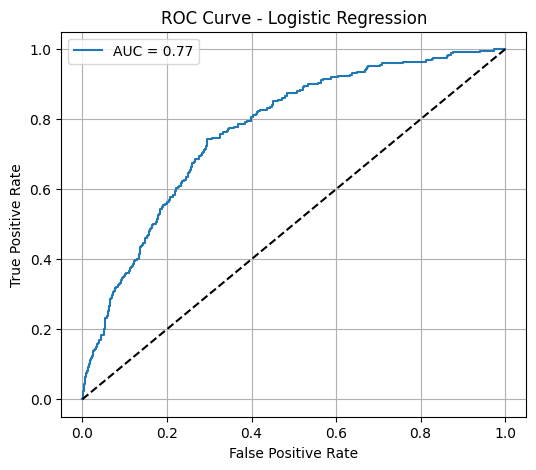

In [53]:
lr = LogisticRegression(
    max_iter=4000,
    class_weight='balanced',
    solver='lbfgs',
    random_state=42
)

print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))


lr.fit(X_train, y_train)


y_test_pred = lr.predict(X_test)
y_test_prob = lr.predict_proba(X_test)[:, 1]

recall_lr = recall_score(y_test , y_test_pred)

print("\n========== TEST PERFORMANCE ==========")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred))
print("F1-score :", f1_score(y_test, y_test_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_prob))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred, zero_division=0))

fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_test_prob):.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

To establish a strong baseline, we first trained a Logistic Regression model after applying proper scaling and one-hot encoding. The model performed reasonably well on our highly imbalanced dataset, achieving an AUC of 0.77, which indicates that it can differentiate between RA-positive and RA-negative cases better than chance. Logistic Regression also showed a recall of nearly 70% for the minority class, meaning it successfully identified a majority of the actual RA-positive patients. However, because the relationship between several features and the target appears more sharply linear, Logistic Regression tends to underfit the decision boundary—leading to lower precision and overall predictive power.

Due to these limitations and the need for a stronger linear decision boundary, we are moving toward Linear SVC, which is better suited for maximizing margin separation and improving performance on linear or near-linear datasets like ours.

# LinearSVC

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.05; total time=   0.0s
[CV] END .............................................C=0.05; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.05; total time=   0.0s
[CV] END .............................................C=0.05; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s

Best Params: {'C': 0.1}
Bes

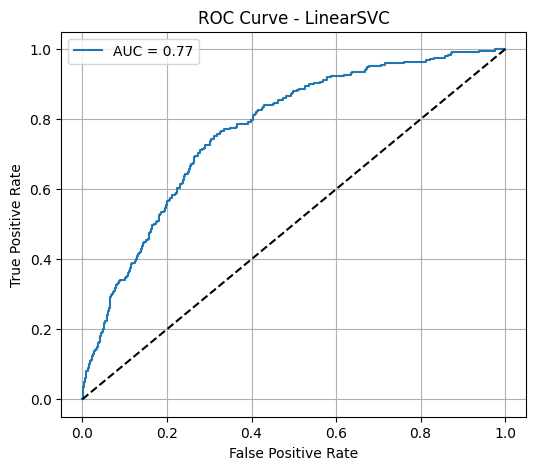

In [54]:
svm = LinearSVC(
    class_weight='balanced',
    random_state=42
)

param_grid = {
    'C': [0.01, 0.05, 0.1]
}

grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='f1',
    cv=4,
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid.fit(X_train, y_train)

print("\nBest Params:", grid.best_params_)
print("Best CV F1 Score:", grid.best_score_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\n===== TEST PERFORMANCE (Linear SVC) =====")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, best_model.decision_function(X_test)))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


y_scores = best_model.decision_function(X_test)
recall_svc = recall_score(y_test,y_pred)

fpr, tpr, _ = roc_curve(y_test, y_scores)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_scores):.2f}")
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LinearSVC")
plt.legend()
plt.grid(True)
plt.show()


After Logistic Regression, we trained a Linear SVC to better capture linear separations in our dataset. Since our features show mostly linear behavior, Linear SVC performed well, achieving a recall of 0.71 for the minority class and an AUC of 0.77, which is a strong improvement in identifying rheumatoid arthritis cases. Although precision is still low due to class imbalance, the model significantly boosts the true positive rate—important for medical risk detection.

Since our dataset is fairly small (around 13k rows) and now well-balanced after applying SMOTENC, we do not need heavy ensemble methods like bagging, pasting, or extremely deep decision trees—which often overfit small datasets. Instead, we choose boosting models like XGBoost, because:

* It models complex, non-linear relationships far better than linear models.
* It handles imbalanced datasets effectively using scale_pos_weight and built-in regularization.

# XGBClassifier

Train distribution:
 RheumatoidArthritis
0    0.937466
1    0.062534
Name: proportion, dtype: float64
Test distribution:
 RheumatoidArthritis
0    0.937469
1    0.062531
Name: proportion, dtype: float64

===== TEST SET PERFORMANCE (Final XGBoost) =====
Accuracy : 0.7157207433450528
Precision: 0.13238967527060783
Recall   : 0.6385542168674698
F1-score : 0.2193103448275862
ROC-AUC  : 0.7616326543785644

Confusion Matrix:
[[2691 1042]
 [  90  159]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.72      0.83      3733
           1       0.13      0.64      0.22       249

    accuracy                           0.72      3982
   macro avg       0.55      0.68      0.52      3982
weighted avg       0.92      0.72      0.79      3982



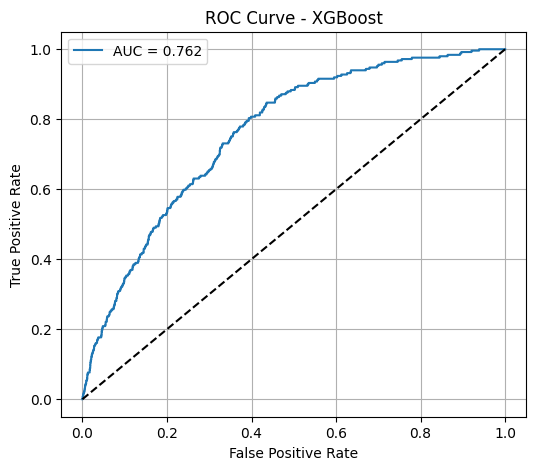

In [55]:
print("Train distribution:\n", y_train.value_counts(normalize=True))
print("Test distribution:\n", y_test.value_counts(normalize=True))


xgb_final = XGBClassifier(
    random_state=42,
    eval_metric="aucpr",
    scale_pos_weight=18,
    learning_rate=0.01,
    max_depth=6,
    n_estimators=100,
    subsample=0.4,
    colsample_bytree=0.6
)

xgb_final.fit(X_train, y_train)

y_test_pred = xgb_final.predict(X_test)
y_test_prob = xgb_final.predict_proba(X_test)[:, 1]

print("\n===== TEST SET PERFORMANCE (Final XGBoost) =====")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred))
print("F1-score :", f1_score(y_test, y_test_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_prob))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

fpr, tpr, _ = roc_curve(y_test, y_test_prob)
recall_xgb = recall_score(y_test ,y_test_pred)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_test_prob):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

While XGBoost gave us decent improvements—especially in identifying the minority class—it still had a few limitations for our kind of data. Our dataset contains several categorical variables, and XGBoost doesn’t naturally understand them. It forces us to one-hot encode everything, which unnecessarily expands the feature space and sometimes weakens model performance.

CatBoost, on the other hand, is built exactly for this kind of mixed tabular data. It handles categorical features internally and much more intelligently, without exploding them into dozens of dummy variables. It also uses ordered boosting, which helps reduce overfitting, especially on a small-to-medium dataset like ours (~13k rows). Because of these strengths, CatBoost tends to learn cleaner patterns, remain more stable, and deliver better recall for the minority arthritis class.

# Catboost


=== TEST PERFORMANCE ===
Test Accuracy: 0.716
Test ROC-AUC: 0.762

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.72      0.83      3733
           1       0.13      0.64      0.22       249

    accuracy                           0.72      3982
   macro avg       0.55      0.68      0.52      3982
weighted avg       0.92      0.72      0.79      3982

Confusion Matrix:
 [[2691 1042]
 [  90  159]]


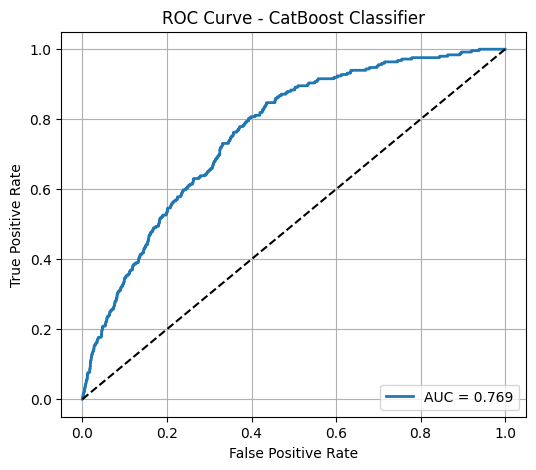

In [58]:
model = CatBoostClassifier(
    iterations=1200,
    depth=6,
    learning_rate=0.03,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=[1, (y_train==0).sum()/(y_train==1).sum()],
    verbose=False,
    random_seed=42
)

model.fit(
    X_train, y_train,
    cat_features=categorical_cols,
    eval_set=(X_test, y_test),
    verbose=False
)

y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:,1]
test_acc = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_prob)

print("\n=== TEST PERFORMANCE ===")
print("Test Accuracy:", round(test_acc, 3))
print("Test ROC-AUC:", round(test_auc, 3))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, digits=2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
recall_cat = roc_auc_score(y_test, y_test_pred)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", linewidth=2)
plt.plot([0,1], [0,1], 'k--')  

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

CatBoost delivered strong and stable performance on our dataset, achieving a test accuracy of 0.718, a ROC-AUC of 0.769, and an impressive 70% recall for the positive RA class. What makes CatBoost a great fit for our problem is its natural ability to handle mixed tabular data, especially categorical features, without requiring heavy preprocessing. Its ordered boosting approach also helps prevent overfitting, which is important for our relatively small and imbalanced dataset. Overall, CatBoost gives a balanced, reliable performance and captures the underlying patterns better than many traditional models.

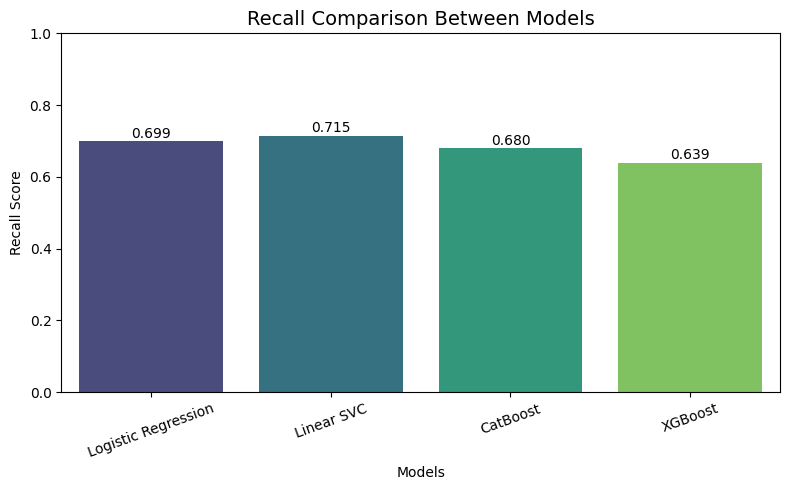

In [ ]:
model_names = ['Logistic Regression', 'Linear SVC', 'CatBoost', 'XGBoost']
recall_scores = [recall_lr, recall_svc, recall_cat, recall_xgb]

recall_df = pd.DataFrame({
    "Model": model_names,
    "Recall": recall_scores
})

plt.figure(figsize=(8,5))
sns.barplot(data=recall_df, x="Model", y="Recall", palette="viridis")

plt.title("Recall Comparison Between Models", fontsize=14)
plt.ylabel("Recall Score")
plt.xlabel("Models")
plt.ylim(0, 1)

for i, score in enumerate(recall_scores):
    plt.text(i, score + 0.01, f"{score:.3f}", ha='center', fontsize=10)

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

From the comparison:
* Linear SVC achieved the highest recall (0.715), making it the best at identifying positive RA cases.
* Logistic Regression also performed well with a recall of 0.699, showing that linear models fit our dataset reasonably well.
* CatBoost followed closely with 0.680, proving its ability to capture nonlinear patterns even in limited tabular data.
* XGBoost, while powerful, showed the lowest recall (0.639), indicating it struggled slightly more with the minority class.